## ReportApp Assist Agent - Proof of Concept 1.1

### Step One: Load Packages
Before we can get started, we must load all of our packages. The main libraries include:
1. LangGraph
2. Langchain AWS
3. Langchain Experimental
4. Typing 
5. Pypdfium2
6. Boto3
7. Pandas

In [ ]:
#!pip install pypdfium2 langgraph langchain langchain-experimental langchain-core langchain-community httpx langchain-aws

In [12]:
import boto3
import logging
import base64
import pypdfium2 as pdfium
import tempfile
import json
import os
import pandas as pd
from typing import Annotated, Union, List, Dict
from typing_extensions import TypedDict

from langchain.pydantic_v1 import BaseModel, Field
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain.tools import StructuredTool, tool
from langchain.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_aws import ChatBedrock
from langchain_aws import AmazonKnowledgeBasesRetriever
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

### Step Two: Load Model
Next, we will load our large language model using AWS bedrock. For this project, we are using Claude Sonnet 3.5. 

In [13]:
modelID = "anthropic.claude-3-5-sonnet-20240620-v1:0"
bedrock_client = boto3.client(
    service_name = "bedrock-runtime",
    region_name = "us-east-1"
)

# loading claude 3 haiku using bedrock client 
llm = ChatBedrock(
    model_id=modelID,
    client=bedrock_client
)

### Step Three: Create Database to Store Memory
To ensure we can store the conversations being held and create persistant conversation, we created a SQlite Saver which stores our conversation in memory. To move into production, we would connect to our own database and store the conversations there. 

In [14]:
memory = SqliteSaver.from_conn_string(':memory:')
# here, we are creating a sqlite server to store our conversatoins 
# it saves it all in memory -- if we productionalized this, we would change this to connect to our down DB or use another checkpointer class 

### Step Four: Define and Load Tools
To handle all of the tasks we need to carry out, we must use an agent that has access to tools. Agentic frameworks enable us to carry out complex tasks that require more than just text generation. 

For our agent, there are a few tools available. 
1. Image Analysis Tool: this tool takes in a PDF of a report and helps the user navigate to a specific view within the report 
2. Search Report App Meta Data Tool: this tool uses RAG to retrieve a recommended report based on the reports key words and description
3. Identify File Paths Tool: this tool uses RAG to retrieve the file paths (CSV or PDF) of a report in question 
    - this will need to be updated for production purposes, as it is not efficient at scale, but for our proof of concept works 
4. Get Data Tool: Reads in CSV data and stores as pandas dataframe 
5. Python Repl Tool: Analyzes and generates insights using python 

In [15]:
### Image Analysis Tool 
def image_analysis_tool(pdf_path):
    runtime = boto3.client("bedrock-runtime",region_name="us-east-1")
    MODEL = "anthropic.claude-3-haiku-20240307-v1:0"
    pdf = pdfium.PdfDocument(pdf_path)
    n_pages = len(pdf)
    # create temporary directory to store images in 
    temp = tempfile.mkdtemp()
    for page_number in range(n_pages):
        page = pdf.get_page(page_number)
        pil_image = page.render(scale=300/72).to_pil()
        pil_image.save(f"{temp}/image_{page_number+1}.png")
        # list all images
    images = os.listdir(temp)
    # store image paths in list to iterate over 
    image_path = []
    for i in images:
        dir_path = os.path.join(temp + '/' + i)
        image_path.append(dir_path)
    print(image_path)
    base64_encoded_pngs = []
    for image in image_path:
        with open(image, "rb") as image_file:
            binary_data = image_file.read()
            base_64_encoded_data = base64.b64encode(binary_data)
            base64_encoded = base_64_encoded_data.decode('utf-8')
            base64_encoded_pngs.append(base64_encoded)
    body = json.dumps({ 
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 17000,
        "messages":[
        {
            "role": "user",
            "content": [
                *[{"type": "image", "source": {"type": "base64", "media_type": "image/jpeg", "data": base64_encoded_png}} for base64_encoded_png in base64_encoded_pngs],
                {
                    "type": "text", 
                    "text": """
                    You are an intelligent business analyst that helps user navigate within reports. You will be given a images of a report and will teach the user how to get to a specific view within the report. 
                    To do this, you will first locate what page the visual or table of interest is in, then you will locate the specific visual or table, and lastly, you will list out in bullet points the steps the users must take to get to those tables or visuals. 
                    Remember, you should not make up information. If you do not have an answer or are unsure of your answer, simply tell the user to either rephrase their question or that you cannot answer right now.
                    """

                }
            ]
        }
        ]
    })

    # Invoke the model\n",
    model_response = runtime.invoke_model(
        modelId=MODEL,
        contentType="application/json",
        accept="application/json",
        body=body
    )
    response_body = json.loads(model_response.get("body").read())
    response = response_body.get("content")
    # convert response to pd dataframe to interact with \n",
    res = pd.DataFrame.from_dict(response)
    response_format = res['text'].values[0]
    # identify start and end tags \n",
    start = response_format.find('>') + 1
    end = response_format.find('</response>')
    # return only the formatted response\n",
    return response_format[start:end]

report_nav_tool = StructuredTool.from_function(
    func = image_analysis_tool,
    name = "image_analysis_tool",
    description = "Useful when you need to describe how to navigate inside of a report. To use this tool, you must provide the PDF path to the report as a string, which you will get from the identify_file_paths_tool."
)

## RETRIEVER TOOL
kb_retriever = AmazonKnowledgeBasesRetriever(
    knowledge_base_id="TROS2O3ULZ", # 👈 Set your Knowledge base ID
    retrieval_config={"vectorSearchConfiguration": {"numberOfResults": 2}},
)

retriever_tool = create_retriever_tool(
    kb_retriever,
    "search_report_app_meta_data",
    "Searches and returns recommended reports based on desired information. Given the user query, provide the name of the report most similiar to their request. Then, pass it to the identify_file_paths tool"
)

## RETRIEVER TOOL - File Locations
kb_retriever_file_locations = AmazonKnowledgeBasesRetriever(
    knowledge_base_id="9EQGP2JNAK", # 👈 Set your Knowledge base ID
    retrieval_config={"vectorSearchConfiguration": {"numberOfResults": 2}},
)

retriever_tool_file_paths = create_retriever_tool(
    kb_retriever_file_locations,
    "identify_file_paths",
    "Retrieves the PDF or CSV file path for a given report. Output of this tool is sent to the image_analysis_tool or the get_data tool"
)

def get_data(csv_path):
    df = pd.read_csv(csv_path)
    return df

get_data = StructuredTool.from_function(
    func = get_data,
    name = "get_data",
    description = "Use this tool when you are asked to generate insights about a report using the underlying data. You will get the csv path from the identify_file_paths tool and then send the data over to the python_repl tool."
)

python_repl = PythonREPL()

repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

tools = [retriever_tool_file_paths, repl_tool, get_data, report_nav_tool, retriever_tool] 
tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)

### Step Five: Construct Graph

"LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner"

In our project, we use langraph to coordinate our Agent and its tools to perform functions to satisfy the question(s) from the user.

Here we:
- Define State: list of messages with a key to track the most recent sender
- Define Agent Nodes: define the node for the Agent
- Define Tool Node: node that runs the tools
- Define Edge Logic: logic that is needed to decide what to do based on the results of the agents

Sources:
- https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141
- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/multi-agent-collaboration.ipynb



In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def reportapp_assist(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("reportapp_assist", reportapp_assist)

tool_node = ToolNode(tools=[retriever_tool_file_paths, repl_tool, get_data, report_nav_tool, retriever_tool] )
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "reportapp_assist",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "reportapp_assist")
graph_builder.set_entry_point("reportapp_assist")

# to ensure we add persistent checkpointing, we will add our sqlite db which stores the session 
graph = graph_builder.compile(checkpointer=memory)

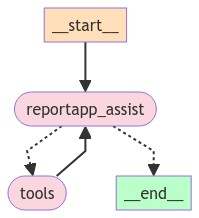

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Step Six: Set up Config for Thread Persistence

In [18]:
# now that we have added in persistence, we need t pick a thread to use as the key for the conversation
config = {'configurable': {'thread_id':'2'}}

## Step Seven: Test Output 

With the graph we created, we can invoke output.

In [19]:
#user_input = "Can you please tell me what reports have information about CPI? Then, can you generate insights from that report?"
user_input = "Hi! My name is Steve. What can you help me do?"

# The config is the **second positional argument** to stream() or invoke()!
## it cannot be nested within the graph inputs 
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Steve. What can you help me do?
================================== Ai Message ==================================

Hello Steve! It's nice to meet you. I'm an AI assistant designed to help you with various tasks related to reports and data analysis. Here are some ways I can assist you:

1. Find relevant reports: I can search for and recommend reports based on specific topics or information you're interested in.

2. Analyze report contents: I can help you navigate through PDF reports and describe their contents.

3. Access and analyze data: If you need insights from data in CSV files, I can help retrieve and analyze that information.

4. Answer questions: I can provide information and insights based on the available reports and data.

5. Perform calculations: If you need any data-related calculations or manipulations, I can use Python to help with that.

Is there a specific task or type of inf

In [10]:
#user_input = "Can you please tell me what reports have information about CPI? Then, can you generate insights from that report?"
user_input = "Can you please tell me what reports have information about CPI? Then, can help me navigate to that report?"

# The config is the **second positional argument** to stream() or invoke()!
## it cannot be nested within the graph inputs 
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you please tell me what reports have information about CPI? Then, can help me navigate to that report?
================================== Ai Message ==================================
Tool Calls:
  search_report_app_meta_data (toolu_bdrk_01AnX6i5E46BeoLAvr3bcYi2)
 Call ID: toolu_bdrk_01AnX6i5E46BeoLAvr3bcYi2
  Args:
    query: CPI Consumer Price Index report
================================= Tool Message =================================
Name: search_report_app_meta_data

,Report,Description,Keywords,Source_Data,Data_Table 0,Economic Indicators - Housing Market," This report provides a comprehensive overview of the housing market, tracking key indicators such as fixed-rate mortgage rates, existing home sales, new single-family home sales, and macroeconomic factors like the S&P CoreLogic Case-Shiller U.S. National Home Price Index, Consumer Price Index (CPI), and unemployment rate. The data is presente

In [21]:
#using PPMS
#user_input = "Can you please tell me what reports have information about CPI? Then, can you generate insights from that report?"
user_input = "Can you please tell me what reports have information about Primary Mortgage Rates in 2023? Then, can help me navigate to that report?"

# The config is the **second positional argument** to stream() or invoke()!
## it cannot be nested within the graph inputs 
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()



================================ Human Message =================================

Can you please tell me what reports have information about Primary Mortgage Rates in 2023? Then, can help me navigate to that report?
================================== Ai Message ==================================
Tool Calls:
  search_report_app_meta_data (toolu_bdrk_01MbjoH8QMV7aARjchYpHsJn)
 Call ID: toolu_bdrk_01MbjoH8QMV7aARjchYpHsJn
  Args:
    query: Primary Mortgage Rates in 2023
================================= Tool Message =================================
Name: search_report_app_meta_data

This report enables monitoring of key economic indicators impacting the housing market and monetary policy over a projected time period. With this data, users can potentially analyze the relationship between mortgage rates, the federal funds rate, and assess the overall state of the mortgage and lending markets.","Primary Mortgage Market Survey, 15-Year Fixed Rate, 30-Year Fixed Rate, Effective Federal Funds

In [13]:
#user_input = "Can you please tell me what reports have information about CPI? Then, can you generate insights from that report?"
user_input = "How did you come to that conclusion?"# Then, can you generate insights from that report?"

# The config is the **second positional argument** to stream() or invoke()!
## it cannot be nested within the graph inputs 
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

In [34]:
user_input = "Ok great! thank you. Can you help me navigate to the CPI visual in that report?"

# The config is the **second positional argument** to stream() or invoke()!
## it cannot be nested within the graph inputs 
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

In [27]:
# now that we have added in persistence, we need t pick a thread to use as the key for the conversation
config = {'configurable': {'thread_id':'2'}}

def generate_response(user_input, config, graph):
    # The config is the **second positional argument** to stream() or invoke()!
    ## it cannot be nested within the graph inputs 
    final_state = graph.invoke(
    {"messages": [("user", user_input)]},
    config={"configurable": {"thread_id": 42}}
    )
    
    return(final_state["messages"][-1].content)
        
generate_response(user_input = 'hi', config=config, graph=graph)

In [16]:
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
final_state = graph.invoke(
    {"messages": [("user", user_input)]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

In [16]:
# data = pd.read_csv('data/file_location_update_test.csv')
# data
# data.loc[1] = [0, 'Primary Mortgage Market Survey', 'PDF/Primary Mortgage Market Survey.pdf', 'data/freddie_pmms.csv']
# data.loc[2] = [0, 'Street Easy Rental Dashboard', 'PDF/Street Easy Rental Dashboard.pdf', 'data/rentalInventory.csv']
# data = data.drop(columns=['Unnamed: 0'])
# data.to_csv('data/file_location_update_test.csv')

### ReportApp Assist - Q&A Example for Insight Generation

In [15]:
user_input = "Hello! What insights can you generate across the Economic Indicators - Housing Market Report and the Primary Mortgage Market Survey Report?"

# The config is the **second positional argument** to stream() or invoke()!
## it cannot be nested within the graph inputs 
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

### ReportApp Assist - Q&A Example for MetaData

In [16]:
user_input = "What reports contain information about CPI? If any, what data source is being used for that report?"

# The config is the **second positional argument** to stream() or invoke()!
## it cannot be nested within the graph inputs 
events = graph.stream(
    {"messages": [("user", user_input)]}, config={"configurable": {"thread_id": 2}}, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

### ReportApp Assist - Q&A Example for Report Navigation

In [ ]:
user_input = "XYZ"

# The config is the **second positional argument** to stream() or invoke()!
## it cannot be nested within the graph inputs 
events = graph.stream(
    {"messages": [("user", user_input)]}, config={"configurable": {"thread_id": 3}}, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()